In [1]:

import torch
import torchvision
import re
import cv2
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import random 
import os, math

LABEL_NAMES = {'none':0, 'q1':1, 'q2':2, 'q3':3, 'q4':4}

LABEL_=['none','q1', 'q2', 'q3', 'q4']

In [2]:
# Set manual seed.
def runRamdomSeed():
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    # Disabling the benchmarking feature with torch.backends.cudnn.benchmark = False 
    # causes cuDNN to deterministically select an algorithm, possibly at the cost of reduced performance.
    torch.backends.cudnn.benchmark = False 

runRamdomSeed()

In [3]:
#img = Image.open('/home/ec2-user/SageMaker/Debug/0.tif').convert('RGB')

In [34]:
import pandas as pd  
from skimage import io 
import csv as csv
class SuperCellDataset(Dataset):
    def __init__(self, image_path):

        self.image_path = image_path
        self.cell_info = pd.read_csv(image_path + 'labels.csv')
        self.length = len(self.cell_info)
        
    def __len__(self):
        return self.length 

    def __getitem__(self, id):
      
        direction = self.cell_info.iloc[id]["Direction"]
        crop_coord = self.cell_info.iloc[id]["Outline"]
        frame = str(self.cell_info.iloc[id]["Frame_Num"])
              #print(frame)
        try:
            full_image_path = self.image_path + frame + ".tif" 
        except: 
            full_image_path = self.image_path + frame + ".tiff"
        img = Image.open(full_image_path).convert('RGB')

        crop_coord = crop_coord.replace('(','').replace(')','')
        crop_coord = crop_coord.split(",")


        direction = direction.replace('[', '').replace(']', '').strip()
        direction = re.sub(' +', ' ', direction)

        direction = direction.split(" ")

        left = int(crop_coord[0])
        right = int(crop_coord[1])
        top = int(crop_coord[2])
        bottom = int(crop_coord[3])

      # https://www.geeksforgeeks.org/python-crop-image-using-pillow/
      #a 4-tuple defining the left, upper, right, and lower pixel coordinate.
        img_cropped = img.crop((left,top,right,bottom))
      #print(type(img_cropped))
      #img_tensor = transforms.ToTensor()(img_cropped)
      
    
        transform = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor()
            ])
      
        try:
            img_tensor = transform((img_cropped))
        except ValueError:
            img_tensor=torch.Tensor()

        label = 0

        x = int(direction[0])
        y = int(direction[1])
 
        mag = (x**2 + y**2)**0.5
        if mag > 3:
            if x > 0:
                if y > 0:
                  label= 1
                else:
                  label= 4
            elif x < 0:
                if y > 0:
                  label = 2
                else:
                  label = 3

        return(img_tensor,label)

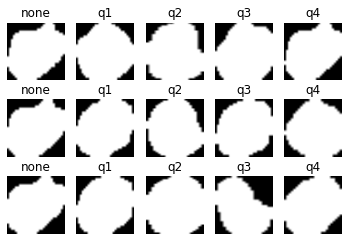

In [35]:
def visualize_data():
    Path_to_your_data= '/home/ec2-user/SageMaker/Processed/'
    
    dataset = SuperCellDataset(Path_to_your_data)

    f, axes = plt.subplots(3, len(LABEL_NAMES))

    counts = [0]*len(LABEL_NAMES)

    for img, label in dataset:
        c = counts[label]

        if c < 3:
            ax = axes[c][label]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis('off')
            ax.set_title(LABEL_[label])
            counts[label] += 1
        
        if sum(counts) >= 3 * len(LABEL_NAMES):
            break

    plt.show()
visualize_data()

In [36]:
class ClassificationLoss(torch.nn.Module):
    def forward(self, input, target):
        """
        Your code here
        Compute mean(-log(softmax(input)_label))
        @input:  torch.Tensor((B,C)), where B = batch size, C = number of classes
        @target: torch.Tensor((B,), dtype=torch.int64)
        @return:  torch.Tensor((,))
        Hint: use torch.nn.functional.nll_loss and torch.nn.functional.log_softmax
        More details: https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.nll_loss).
        """
        #print(target.shape)
        neg_log = torch.nn.functional.nll_loss(torch.nn.functional.log_softmax(input), target=target, reduction='mean')

        return neg_log

In [37]:
def init_weights(net):
    """
    Usage: net = Model()
           net.apply(init_weights)
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class DirCellClassifier(torch.nn.Module):
    def __init__(self):
        """
        Task: create a model with:
          2 convolutional layers, followed by 2 linear layers, the last of which should output the logits for each class.
          Check the table given above (section 3.3.2) for more details in the specification.
        """
        # Don't remove the following line. Otherwise, it would raise ```AttributeError: cannot assign module before Module.__init__() call``` exception ERROR!
        super(DirCellClassifier, self).__init__() 
        
        # YOUR CODE HERE 
        #self.conv1 = nn.Conv2d(3, 8, 4, 2)
        #self.conv2 = nn.Conv2d(8, 16, 4, 2)
        #self.dropout1 = nn.Dropout(0.25)
        #self.fc1 = nn.Linear(3136, 128)
        #self.dropout2 = nn.Dropout(0.1)
        #self.fc2 = nn.Linear(128, 3)
        
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size=5, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size=5, stride=1,  padding=1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels = 32, out_channels = 40, kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(in_channels = 40, out_channels = 32, kernel_size=5, stride=1,  padding=1)
        self.pool6 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = torch.nn.Conv2d(in_channels = 32, out_channels = 48, kernel_size=5, stride=1,  padding=1)
        self.conv8 = torch.nn.Conv2d(in_channels = 48, out_channels = 64, kernel_size=5, stride=1,  padding=1)
        self.pool9 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        #self.conv10 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=5, stride=1,  padding=1)
        #self.conv11 = torch.nn.Conv2d(in_channels = 64, out_channels = 72, kernel_size=5, stride=1,  padding=1)
        #self.pool12 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1_layer = torch.nn.Linear(1600, 1000)
        self.fc2_layer = torch.nn.Linear(1000, 5)
       

    def forward(self, x):
        """
        Your code here
        @Brief: This function takes as input a tensor x of size Bx3x64x64 
        and outputs a "logit" tensor of size Bx6. Do not include a softmax layer 
        here because most of Pytorch's loss functions take "logit" as one of the inputs
        while integrating log() with softmax() into a log_softmax() function.    
        @Inputs: 
          x: torch.Tensor((B,3,64,64)) 
        @return: torch.Tensor((B,6))
        @Note: After the 2nd Conv2d (and ReLU), the intermediate feature has the shape 
               ```B x 16 x 14 x 14```. Before putting it into layer 3 (Linear), 
               make sure to reshape this intermediate feature to ```B x 3136```.
        """

        
             
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool9(x)
        #x = self.conv10(x)
        #x = self.conv11(x)
        #x = self.pool12(x)
        #print(x.shape)
        x = torch.reshape(x, (x.size(0), -1))
        

        x = self.fc1_layer(x)
        output = self.fc2_layer(x)

        return output

def test_DirCellClassifier():
    # Run randomseed here to ensure results are consistent
    runRamdomSeed()
    student_net = DirCellClassifier()

    # Investigate your network's layers
    # Compare the printed shape with what expected in the specification
    print("\n========= Model summarization ============ ") 
    student_net_info = summary(student_net, (3, 64, 64), device='cpu')

  
    # Check the number of Conv2d layers and Linear layers
    total_conv2d = student_net_info['total_conv2d']
    total_linear = student_net_info['total_linear']
    if total_conv2d != 2:
        print(f"[FAIL!] BasicCNNClassifier.forward(...) must contains exactly 2 Conv2d layers!, but yours consists of: {total_conv2d} Conv2d layers")
        return 
    if total_linear != 2:
        print(f"[FAIL!] BasicCNNClassifier.forward(...) must contains exactly 2 Linear layers!, but yours consists of: {total_linear} Linear layers")
        return 

    # Check total number of parameters
    total_parmas = student_net_info['total_params']
    if total_parmas != 404766:
        print(f"[FAIL!] BasicCNNClassifier.forward(...) must contains exactly 404,766 parameters!, but yours consists of: {total_parmas} parameters")
        print(f"Check kernel size, stride, no of input features, no of output featurs of your Conv2d layer,")
        print(f"\t and no of input features, no of output featurs of your Linear layer")
        return 

    # Initialize weights for this network
    student_net.apply(init_weights)

    # Give the network a dummy input of size 2x3x64x64
    batch_size  = 2
    dummy_x  = torch.randn([batch_size, 3, 64, 64])
    logit    = student_net(dummy_x) 

    print("========= Run Model with Dummy Input ============\n") 
    # Check type of the output logit
    if not torch.is_tensor(logit):
        print(f"[FAIL!] BasicCNNClassifier.forward(...) must return a tensor!, but yours returns: {type(logit)}")
        return 

    # Check size of the output logit
    if logit.size() != torch.Size([2,6]):
        print(f"[FAIL!] BasicCNNClassifier.forward(...) must return a tensor of size torch.Size([2,6])!, but your return's size: {logit.size()}")
        print(f"Make sure that the number of layers, the layers, number of features, kernel size ... all are correct!")
        return
  
    # Check value
    expected_logit = torch.tensor([[-1.7501, -2.2915,  0.2061, -0.9353,  0.5314,  1.1240],
                                   [-1.3631, -1.3827,  1.7212, -0.1081, -1.3976,  2.3925]])

    if torch.norm(logit - expected_logit) > 1e-3:
        print(f"[FAIL!] BasicCNNClassifier.forward(...) must return \n {expected_logit}")
        print(f"However, yours returns: \n{logit}")
        print(f"Make sure that the number of layers, the layers, number of features, kernel size ... all are correct!")
        return

    # Check to see if we can do backpropagation
    base_loss_obj  = torch.nn.CrossEntropyLoss(reduction='mean')  
    dummy_target   = torch.randint(0, 6, [2])
    loss           =  base_loss_obj(logit, dummy_target)
    loss.backward()
    print(f"Target: {dummy_target}")
    print(f"Logit: {logit}")
    print(f"Loss: {loss.item()}")



    print("----------------------------------------------------------------------------------") 
    print("\n[SUCCESSFUL!] Congrats! Your implementation of ClassificationLoss looks correct!")

In [39]:
# DO NOT TOUCH THIS CELL!
import numpy as np
from torchvision.transforms import functional as TF

def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

def predict(model, inputs, device='cpu'):
    inputs = inputs.to(device)
    logits = model(inputs)
    return F.softmax(logits, -1)

def draw_bar(axis, preds, labels=None):
    y_pos = np.arange(6)
    axis.barh(y_pos, preds, align='center', alpha=0.5)
    axis.set_xticks(np.linspace(0, 1, 10))
    
    if labels:
        axis.set_yticks(y_pos)
        axis.set_yticklabels(labels)
    else:
        axis.get_yaxis().set_visible(False)
    
    axis.get_xaxis().set_visible(False)

def visualize_predictions(model=None, model_name=None, device_name='cpu'):
  
    if model is not None:
        model.eval()
    else:
        model = load_model(model_name, device_name)
    
    # Get the device 
    if device_name is not None:
        device = torch.device(device_name)
    model = model.to(device)

    validation_image_path='/home/ec2-user/SageMaker/Processed_Valid/' #enter the path 

    dataset = SuperCellDataset(image_path=validation_image_path)

    f, axes = plt.subplots(2, 6)

    idxes = np.random.randint(0, len(dataset), size=6)

    for i, idx in enumerate(idxes):
        img, label = dataset[idx]
        preds = predict(model, img[None], device=device).detach().cpu().numpy()

        axes[0, i].imshow(TF.to_pil_image(img))
        axes[0, i].axis('off')
        draw_bar(axes[1, i], preds[0], LABEL_ if i == 0 else None)

    plt.show()

In [40]:
def collate_fn(data):
    img = [item[0] for item in data]
    label = [item[1] for item in data]

    #zipped = zip(img, label)
    
    return [img, label]

In [41]:
def load_data(dataset_path, data_transforms=None, num_workers=0, batch_size=128):
    dataset = SuperCellDataset(dataset_path)
    return DataLoader(dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True)

In [49]:
class Args(object):
    pass

args = Args();
# Add attributes to args here, such as:
args.learning_rate = 0.05

In [50]:
def get_accuracy(pred, actual):
  assert len(pred) == len(actual)

  total = len(actual)
  _, predicted = torch.max(pred.data, 1)
  correct = (predicted == actual).sum().item()
  return correct / total

In [51]:
from torch import save
from torch import load



def save_model(model, name):
    if isinstance(model, DirCellClassifier):
        return save(model.state_dict(), name + ".pth")
    
    raise ValueError("model type '%s' not supported!"%str(type(model)))


def load_model(name, device_name='cpu'):
    """
    @Brief: load a model saved in the ".pth" or ".pt" formats
    @Inputs:
        name (str): name of the model (without the extension)
        device_name (str): name of the device i.e: 'cpu', 'cuda:0', that you would want to run the model on.
    @Outputs:
        r (nn.Module): a Pytorch model of either "BasicCNNClassifier" or "MyBestCNNClassifier" (depend on "name" input) 
            with pretrained wieghts.
    """
    # In case students set input name = "*.pth" 
    if "." in name:
        name = name.split('.')[0]
        
    if name == "DirCellClassifier":
        r = BasicCNNClassifier()
    elif name == "DirCellClassifier":
        r = MyBestCNNClassifier()
    else:
        raise ValueError(f"model {name} has not been supported! Check the spelling!")
    r.load_state_dict(load(name + ".pth", map_location=device_name))
    return r

In [52]:
def train(args, model_name="MyBestCNNClassifier"):
    """
    @Brief: training your model. This should include the following items:
        - Initialize the model (already given). Only need to map the model to the device on which you would want to run the model on 
                using the following syntax: 
                model = model.to(device) 
                where device = torch.device(<device_name>), 
                i.e: device = torch.device("cuda:0") or device = torech.device("cpu")
                    
        - Initialize tensorboard summarizers (already given)
        - Initialize data loaders (you need to code up)
        - Initialize the optimizer (you need to code up. Type is of your choice)
        - Initialize the loss function (you should have coded up above)
        - A for loop to iterate through many epochs (up to your choice). In each epoch:
                - Iterate through every mini-batches (remember to map data and labels to the device that you would want to run the model on)
                        - Run the forward path
                        - Get loss
                        - Calculate gradients 
                        - Update the model's parameters
                - Evaluate your model on the validation set
                - Save the model if the performance on the validation set is better using exactly the following line:
                        save_model(model, model_name) 
                 
    @Inputs: 
        Args: object of your choice to carry arguments that you want to use within your training function. 
    @Output: 
        No return is necessary here. 
    """
    model = DirCellClassifier()

    #device=torch.device('cpu')
    #model=model.to(device)

    train=load_data('/home/ec2-user/SageMaker/Processed/')
    val = load_data('/home/ec2-user/SageMaker/Processed_Valid/')
    optimizer=torch.optim.Adam(model.parameters())
    loss=ClassificationLoss()
    model.apply(init_weights)
    epochs=100

    acc = 0
    model.train()

    for e in range(epochs):
    # clearing the Gradients of the model parameters
      
      optimizer.zero_grad()
    
      
      for (X,Y) in train:
        if (len(X) !=0):
            #X = np.expand_dims(X, 1)
                    
            #X = np.squeeze(X)
                    
            #X = transforms.ToTensor()(X)
            #x_it = x_it.unsqueeze(1)
            #print(x_it)
            #print(X.shape)
            output_train = model.forward(X)
            #print(output_train.shape)
            #Y = Y.squeeze(1)
            #Y = Y.unsqueeze(1).unsqueeze(1)
            loss_train = loss(output_train, Y)
            loss_train.backward()
            optimizer.step()

      preds = []
      labels = []
      for (X,Y) in val:
        if (len(X) != 0):
            #print(X.shape)
            y_pred = torch.argmax(model(X), dim = 1).tolist()
            y_pred = map(int, y_pred)
            preds.extend(list(y_pred))
            labels.extend(Y.tolist())
      new_acc = np.sum(np.array(preds) == np.array(labels))/len(np.array(preds))
      if (new_acc > acc):
        acc = new_acc
        save_model(model, model_name)
      #print("Prediction:", preds)
      #print("Real:", labels)  
      print('Epoch : ',e+1, '\t', 'accuracy :', acc)

    

In [53]:
train(args, model_name="DirCellClassifier")

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch :  1 	 accuracy : 0.06329113924050633
Epoch :  2 	 accuracy : 0.06329113924050633
Epoch :  3 	 accuracy : 0.8020713463751439
Epoch :  4 	 accuracy : 0.8020713463751439
Epoch :  5 	 accuracy : 0.8020713463751439
Epoch :  6 	 accuracy : 0.8020713463751439
Epoch :  7 	 accuracy : 0.8020713463751439
Epoch :  8 	 accuracy : 0.8020713463751439
Epoch :  9 	 accuracy : 0.8020713463751439
Epoch :  10 	 accuracy : 0.8020713463751439
Epoch :  11 	 accuracy : 0.8020713463751439
Epoch :  12 	 accuracy : 0.8020713463751439
Epoch :  13 	 accuracy : 0.8020713463751439
Epoch :  14 	 accuracy : 0.8020713463751439
Epoch :  15 	 accuracy : 0.8020713463751439
Epoch :  16 	 accuracy : 0.8020713463751439
Epoch :  17 	 accuracy : 0.8020713463751439
Epoch :  18 	 accuracy : 0.8020713463751439
Epoch :  19 	 accuracy : 0.8020713463751439
Epoch :  20 	 accuracy : 0.8020713463751439
Epoch :  21 	 accuracy : 0.8020713463751439
Epoch :  22 	 accuracy : 0.8020713463751439
Epoch :  23 	 accuracy : 0.802071346375

KeyboardInterrupt: 